<a href="https://colab.research.google.com/github/AntoninaRemizova/Minor/blob/main/%D0%A0%D0%B5%D0%BC%D0%B8%D0%B7%D0%BE%D0%B2%D0%B0_%D0%B4%D0%B73_(%D0%92%D0%B5%D1%82%D0%B2%D1%8F%D1%89%D0%B8%D0%B5%D1%81%D1%8F_%D0%BF%D1%80%D0%BE%D1%86%D0%B5%D1%81%D1%81%D1%8B).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Загрузка данных

In [2]:
url = "https://raw.githubusercontent.com/AntoninaRemizova/Minor/main/Japan.xlsx"
data = pd.read_excel(url)
data['Дата'] = pd.to_datetime(data['Дата'], dayfirst=True, format='%d.%m.%Y')
data

,Страна,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день,Население страны,Тестов,Тестов за день
0,Япония,2020-07-20,25680,19603.0,988,418,392.0,2,127110047,562726,12114
1,Япония,2020-07-21,26312,20001.0,989,632,398.0,1,127110047,579083,16357
2,Япония,2020-07-22,27107,20482.0,990,795,481.0,1,127110047,587393,8310
3,Япония,2020-07-23,28088,20878.0,992,981,396.0,2,127110047,593088,5695
4,Япония,2020-07-24,28867,21173.0,995,779,295.0,3,127110047,602618,9530
...,...,...,...,...,...,...,...,...,...,...,...
604,Япония,2022-03-16,5913591,NaN,26625,57822,NaN,163,127110047,40063837,156343
605,Япония,2022-03-17,5967069,NaN,26796,53478,NaN,171,127110047,40240745,176908
606,Япония,2022-03-18,6016178,NaN,26952,49109,NaN,156,127110047,40335554,94809
607,Япония,2022-03-19,6060771,NaN,27056,44593,NaN,104,127110047,40388920,53366


# Нормировка

In [3]:
population = data['Население страны'].iloc[0]
daily_infected = data['Заражений за день'].values[425:456]
normalized_infected = (daily_infected / population) * 100000
print(normalized_infected)

[3.6975834  2.67170069 1.74730484 1.39249417 2.55133255 2.83297826
 1.64817813 2.10054206 1.68043365 0.90315441 1.35473162 1.56006551
 1.2390838  1.1360235  0.9778928  0.76075812 0.4712452  0.77019876
 0.88505986 0.76469172 0.65061733 0.60892118 0.43505609 0.29029963
 0.47753896 0.57509223 0.48540616 0.40673417 0.39335994 0.33671611
 0.18094557]


In [4]:
normalized_infected = normalized_infected.astype(int).round()
print(normalized_infected)

[3 2 1 1 2 2 1 2 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


# Оценка среднего числа потомков ($\mu$)

In [5]:
mu_estimate = np.mean(normalized_infected)
print(f"Оценка среднего числа потомков (μ): {mu_estimate}")

Оценка среднего числа потомков (μ): 0.6129032258064516


# Определение типа процесса

In [6]:
if mu_estimate < 1:
    process_type = "докритический"
elif mu_estimate == 1:
    process_type = "критический"
else:
    process_type = "надкритический"
print(f"Тип процесса - {process_type}")

Тип процесса - докритический


# Оценка вероятности отсутствия потомков (p)

In [7]:
p_estimate = 1 / (mu_estimate + 1)
print(f"Оценка вероятности отсутствия потомков (p): {p_estimate}")

Оценка вероятности отсутствия потомков (p): 0.62


# Вероятность вырождения процесса

In [8]:
if p_estimate >= 0.5:
    q_extinction = 1
else:
    q_extinction = p_estimate / (1 - p_estimate)
print(f"Вероятность вырождения: {q_extinction}")

Вероятность вырождения: 1


# Среднее время до вырождения

In [9]:
if process_type == "докритический":
    N = 1
    ET = np.log(N) / np.abs(np.log(mu_estimate))
    print(f"Среднее время до вырождения: {ET} дней")
else:
  print("Процесс не докритический")

Среднее время до вырождения: 0.0 дней


# Моделирование 5 траекторий ветвящегося процесса

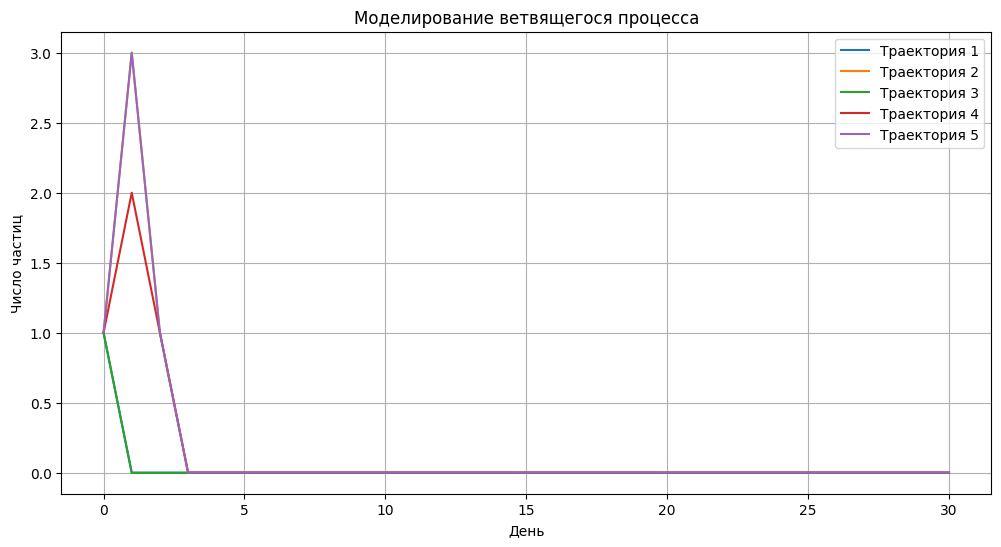

In [12]:
def simulate_branching_process(mu, days=30, trajectories=5):
    np.random.seed(42)
    all_trajectories = []
    for _ in range(trajectories):
        particles = [1]
        for day in range(1, days+1):
            new_particles = 0
            for _ in range(particles[-1]):
                offspring = np.random.geometric(p=1/(mu + 1)) - 1
                new_particles += offspring
            particles.append(new_particles)
        all_trajectories.append(particles)
    return all_trajectories

trajectories = simulate_branching_process(mu_estimate, days=30, trajectories=5)

plt.figure(figsize=(12, 6))
for i, traj in enumerate(trajectories):
    plt.plot(traj, label=f'Траектория {i+1}')
plt.title('Моделирование ветвящегося процесса')
plt.xlabel('День')
plt.ylabel('Число частиц')
plt.legend()
plt.grid()
plt.show()

# Сравнение с реальными данными

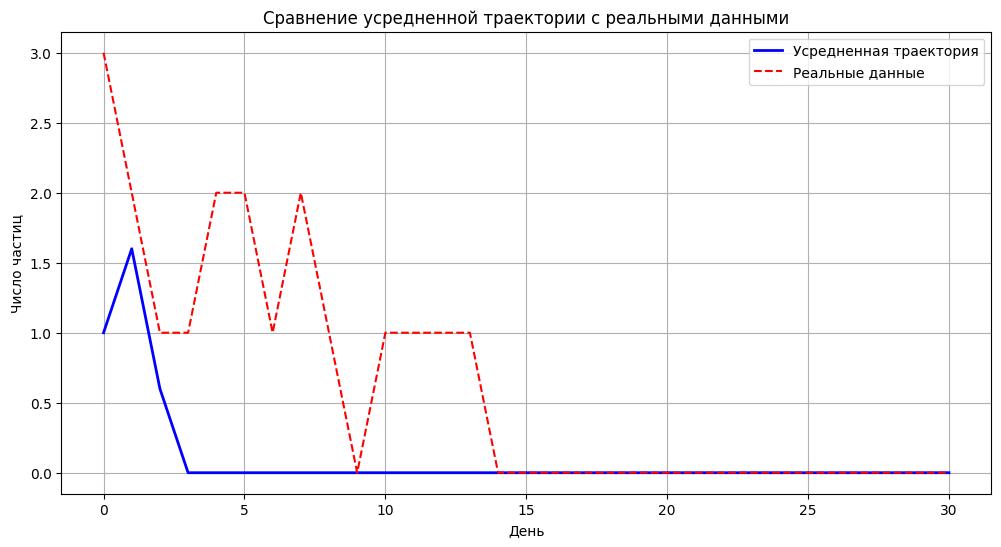

In [13]:
average_trajectory = np.mean(trajectories, axis=0)
plt.figure(figsize=(12, 6))
plt.plot(average_trajectory, label='Усредненная траектория', color='blue', linewidth=2)
plt.plot(normalized_infected, label='Реальные данные', color='red', linestyle='--')
plt.title('Сравнение усредненной траектории с реальными данными')
plt.xlabel('День')
plt.ylabel('Число частиц')
plt.legend()
plt.grid()
plt.show()